In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyro

# Chapter 3 Exercises

## 3M1
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.


In [51]:
# we want to estimate the distribution of the parameter p. We do this through a normal
def posterior(seq, points):
    # number of W
    W = torch.tensor(sum([1 if (i == "W") else 0 for i in seq]))
    # prior
    prior = torch.distributions.Uniform(0, 1)
    
    # define grid
    grid = torch.linspace(0, 1, points)
    posterior = np.zeros(points)
    
    # compute posterior at each point in grid
    for i, p in enumerate(grid):
        likelihood = torch.distributions.Binomial(len(seq), p)
        posterior[i] = np.exp(prior.log_prob(p) + likelihood.log_prob(W))
    
    # normalize posterior
    posterior = posterior / posterior.sum()
    
    plt.plot(grid, posterior, marker="*")
    plt.title(f"{seq}, npoints= {points}")
    plt.show()
    
    return grid, posterior

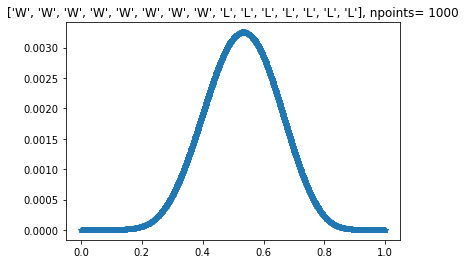

In [155]:
grid, post = posterior(8*["W"] + 7*["L"], 1000)

## 3M2
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPD

In [167]:
# pyro distribution
d = pyro.distributions.Categorical(torch.tensor(post))
# sample
samples = [d.sample().item() for i in range(10000)]

In [168]:
high, low = pyro.ops.stats.hpdi(torch.tensor(samples), 0.9)
print(grid[high], grid[low])

tensor(0.3333) tensor(0.7247)


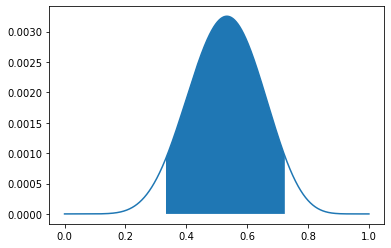

In [169]:
fig, ax = plt.subplots(1)
ax.plot(grid, post)
ax.fill_between(grid[high:low], post[high:low])
plt.show()

# 3M3
Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?


In [170]:
# generate predictive posterior at each value of p in the grid
raw = np.zeros((len(grid), 15))
post_pred = np.zeros(15)
for i in range(len(grid)):
    b = torch.distributions.Binomial(15, grid[i])
    raw[i] = np.array([torch.exp(b.log_prob(i)).item() for i in torch.arange(0, 15)])
    post_pred += raw[i] * post[i]

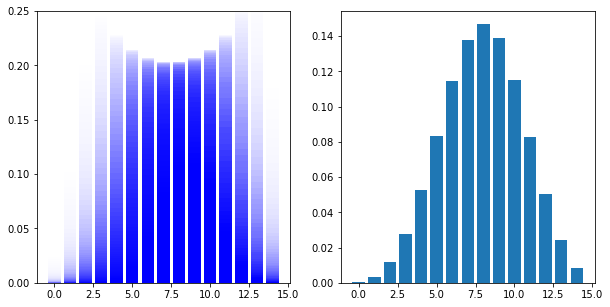

In [171]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
for i in range(0, len(grid), 5):
    axes[0].bar(range(15), raw[i], alpha=post[i]*20, color="b")
axes[1].bar(range(15), post_pred)
axes[0].set_ylim(0, 0.25)
plt.show()

In [174]:
print("Probability of 8 waters: ", post_pred[8])

Probability of 8 waters:  0.14696804756049855


# 3M4
Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [176]:
# generate predictive posterior at each value of p in the grid
raw = np.zeros((len(grid), 9))
post_pred = np.zeros(9)
for i in range(len(grid)):
    b = torch.distributions.Binomial(9, grid[i])
    raw[i] = np.array([torch.exp(b.log_prob(i)).item() for i in torch.arange(0, 9)])
    post_pred += raw[i] * post[i]

In [178]:
print("Probability of 6 waters: ", post_pred[6])

Probability of 6 waters:  0.17638978985201711


# 3M5
Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0.7.


### Posterior

In [181]:
def posterior(seq, points):
    # number of W
    W = torch.tensor(sum([1 if (i == "W") else 0 for i in seq]))
    # prior
    prior = lambda x: 0 if x < 0.5 else 1
    
    # define grid
    grid = torch.linspace(0, 1, points)
    posterior = np.zeros(points)
    
    # compute posterior at each point in grid
    for i, p in enumerate(grid):
        likelihood = torch.distributions.Binomial(len(seq), p)
        posterior[i] = np.exp(np.log(prior(p)) + likelihood.log_prob(W))
    
    # normalize posterior
    posterior = posterior / posterior.sum()
    
    plt.plot(grid, posterior, marker="*")
    plt.title(f"{seq}, npoints= {points}")
    plt.show()
    
    return grid, posterior

<ipython-input-181-454e7fa6379a>:14: RuntimeWarning: divide by zero encountered in log
  posterior[i] = np.exp(np.log(prior(p)) + likelihood.log_prob(W))


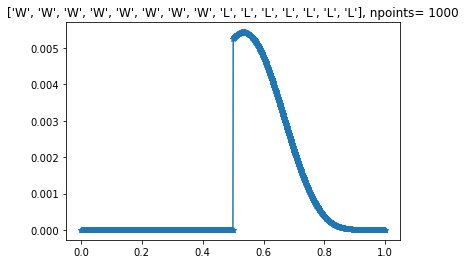

In [182]:
grid, post = posterior(8*["W"] + 7*["L"], 1000)

### HDPI

In [183]:
# pyro distribution
d = pyro.distributions.Categorical(torch.tensor(post))
# sample
samples = [d.sample().item() for i in range(10000)]

high, low = pyro.ops.stats.hpdi(torch.tensor(samples), 0.9)
print(grid[high], grid[low])

tensor(0.5005) tensor(0.7127)


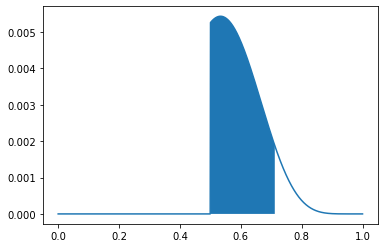

In [184]:
fig, ax = plt.subplots(1)
ax.plot(grid, post)
ax.fill_between(grid[high:low], post[high:low])
plt.show()

### Predictive Posterior

In [189]:
# generate predictive posterior at each value of p in the grid
raw = np.zeros((len(grid), 15))
post_pred = np.zeros(15)
for i in range(len(grid)):
    b = torch.distributions.Binomial(15, grid[i])
    raw[i] = np.array([torch.exp(b.log_prob(i)).item() for i in torch.arange(0, 15)])
    post_pred += raw[i] * post[i]

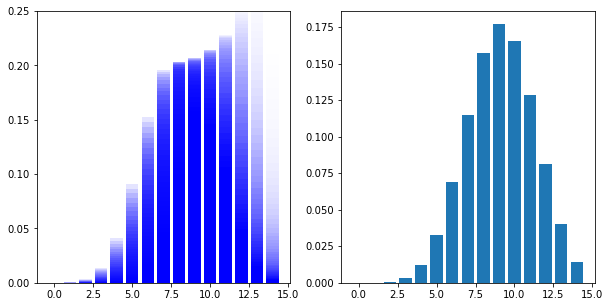

In [190]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
for i in range(0, len(grid), 5):
    axes[0].bar(range(15), raw[i], alpha=post[i]*20, color="b")
axes[1].bar(range(15), post_pred)
axes[0].set_ylim(0, 0.25)
plt.show()

In [191]:
print("Probability of 8 waters: ", post_pred[8])

Probability of 8 waters:  0.15722798249259498


### Prob of 6 waters

In [192]:
# generate predictive posterior at each value of p in the grid
raw = np.zeros((len(grid), 9))
post_pred = np.zeros(9)
for i in range(len(grid)):
    b = torch.distributions.Binomial(9, grid[i])
    raw[i] = np.array([torch.exp(b.log_prob(i)).item() for i in torch.arange(0, 9)])
    post_pred += raw[i] * post[i]

In [193]:
print("Probability of 6 waters: ", post_pred[6])

Probability of 6 waters:  0.23230708749323412


### Analysis
The new prior shifts the distribution of the parameter p to the right. It better expresses the true parameter 0.7